In [1]:
import pymongo
import pandas as pd 
import numpy as np  
import re
import seaborn as sns
from pyecharts import options as opts 
from pyecharts.charts import Pie
import matplotlib.pyplot as plt 
%matplotlib inline
sns.set_style('white',{'font.sans-serif':['simhei','Arial']})

In [2]:
pd.set_option('display.max_columns',None)


In [3]:
client = pymongo.MongoClient(host = '127.0.0.1' , port = 27017)
db = client['spider']
collection = db['lagou']

In [4]:
data = collection.find()

In [5]:
df = pd.DataFrame(list(data))

In [6]:
#  取出分析所需要的字段
columns = ['positionName','companyShortName','city','companySize','education','financeStage','industryField','salary','workYear','hitags','companyLabelList','skillLables']

In [7]:
df1 = df[columns]

In [8]:
#  数据分析相应岗位数量
cond1 = df1.positionName.str.contains('数据分析')
cond2 = df1.positionName.str.contains('实习')
# 过滤实习的工作  
df1 = df1[cond1 & ~cond2]

###  讲拉勾网的薪水转换成数值

In [9]:
df1.dropna(axis = 0 , subset = ['salary'],inplace = True)

In [10]:
def salary(loc):
    List = list()
    for k in loc:
        li = re.findall(r'(\d+)k-(\d+)k',k)
        if not li:
            List.append(np.nan)
        else:
            List.append((int(li[0][0]) + int(li[0][1])) / 2 )
    return List
            

In [11]:
#  将薪水转化为数值类型
df1.salary = salary(df1.salary)

In [12]:
# 计算平均薪水
avg_salary = df1.salary.mean().round(2)

In [13]:
# 采用均值填充
df1.salary.fillna(avg_salary,inplace=True)

In [14]:
def  skillrequire(labels):
    count_dict = {}
    for lab in labels:
        if lab ==[]:
            continue
        for word in lab:
            if '数据' in word:
                continue
            if word in count_dict:
                count_dict[word] += 1
            else:
                count_dict[word] = 1
    return count_dict

In [15]:
#  生成技能列
count_dict = skillrequire(df1.skillLables)

In [16]:
#  所需技能排行前10
skill_df = pd.DataFrame(sorted(count_dict.items(), key = lambda x:x[1],reverse = True)[:10])

In [17]:
skill_df.columns = ['skill','number']
# skill_df.set_index('skill',inplace = True)

###  生成技能要求的词云图

In [18]:
from wordcloud import WordCloud

g:\program files (x86)\python37\lib\site-packages\wordcloud\wordcloud.py:995: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


(-0.5, 299.5, 299.5, -0.5)

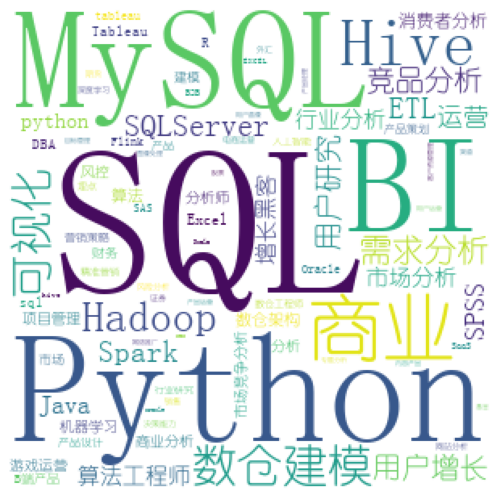

In [19]:
plt.figure(figsize=(12,8),dpi = 80)
font_path = './data/SIMYOU.TTF'
mask = plt.imread('./data/cxy.jpg')
wc = WordCloud(font_path=font_path,mask=mask, width=1000, height=618,background_color='white')
wc.fit_words(count_dict)
plt.imshow(wc)
plt.axis('off')

###  处理行业信息

In [20]:
def clean_industry(industry):
    if not industry:
        return '移动互联网'
    industry = industry.split(',')
    if industry[0]=="移动互联网" and len(industry)>1:
        return industry[1]
    else:
        return industry[0]

In [21]:
df["industryField"] = df.industryField.map(clean_industry)

### 各城市对数据分析岗位的要求

Text(0, 0.5, '')

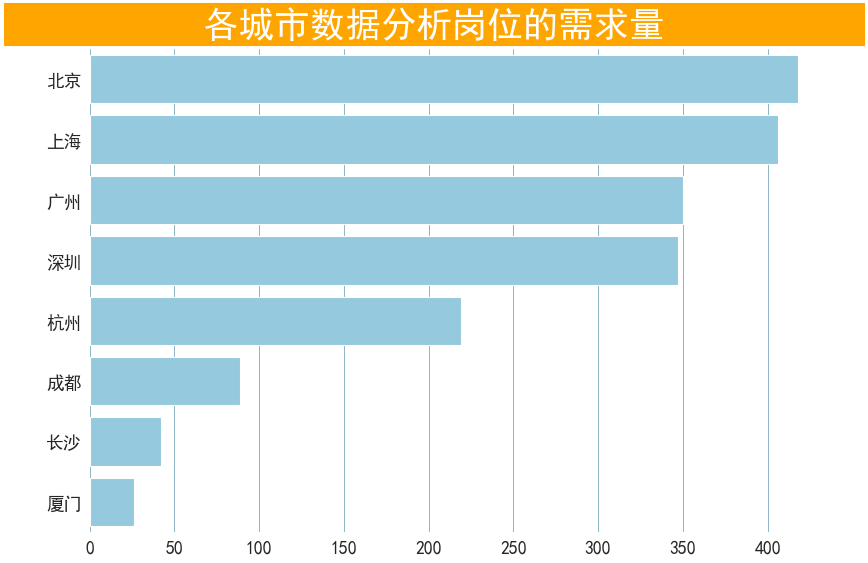

In [22]:
fig ,ax = plt.subplots(figsize = (12,8),dpi = 80)
sns.countplot(y = 'city',order=df1['city'].value_counts().index,data = df1,color='skyblue')
fig.text(x = 0.04,y = 0.90,s = '           各城市数据分析岗位的需求量           ',fontsize = 32,weight = 'bold',color= 'white',backgroundcolor = 'orange')
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.box(False)
plt.xlabel('')
plt.ylabel('')

###  不同细分领域对数据分析岗的需求量

In [23]:
industry_index = df1.industryField.value_counts()[:10].index
industry = df1.loc[df1['industryField'].isin(industry_index),"industryField"]

Text(0, 0.5, '')

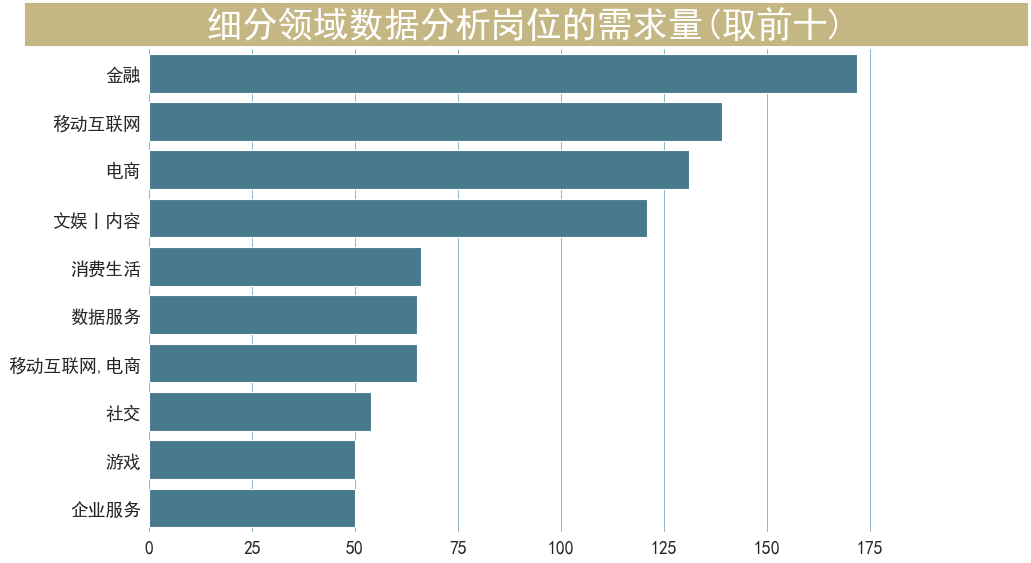

In [24]:
fig,ax = plt.subplots(figsize = (12,8),dpi = 80)
sns.countplot(y = industry.values,order=industry_index , color='#3c7f99')
plt.box(False)
fig.text(x = 0, y = 0.90 , s = "          细分领域数据分析岗位的需求量(取前十)          ",fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('')
plt.ylabel('')

###  各城市相应岗位的薪资状况

g:\program files (x86)\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0, 0.5, '')

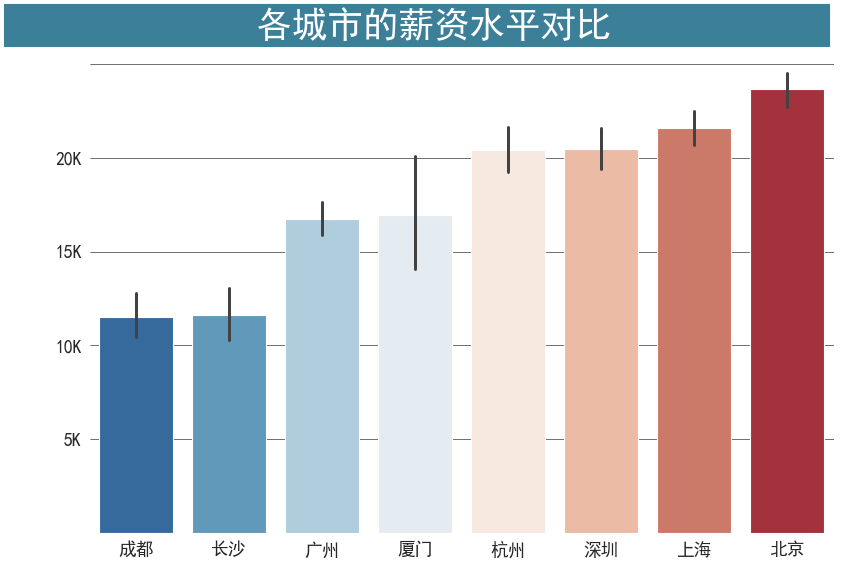

In [25]:
fig ,ax = plt.subplots(figsize= (12,8),dpi= 80)
city_order = df1.groupby('city')['salary'].mean().sort_values().index.tolist()
sns.barplot(x = 'city',y = 'salary',order= city_order,data = df1 , ci = 95 , palette="RdBu_r")
fig.text(x =0.04,y = 0.90,s = "              各城市的薪资水平对比            ",fontsize = 32, weight = 'bold', color = 'white' , backgroundcolor = '#3c7f99')
plt.tick_params(axis = 'both',labelsize = 16)
ax.yaxis.grid(which='both',linewidth = 0.5,color = 'black')
ax.set_yticklabels(["" , "5K","10K","15K","20K"])
plt.box(False)
plt.xlabel("")
plt.ylabel("")

In [26]:
city_order

['成都', '长沙', '广州', '厦门', '杭州', '深圳', '上海', '北京']

 ###  一线城市薪资分布对比

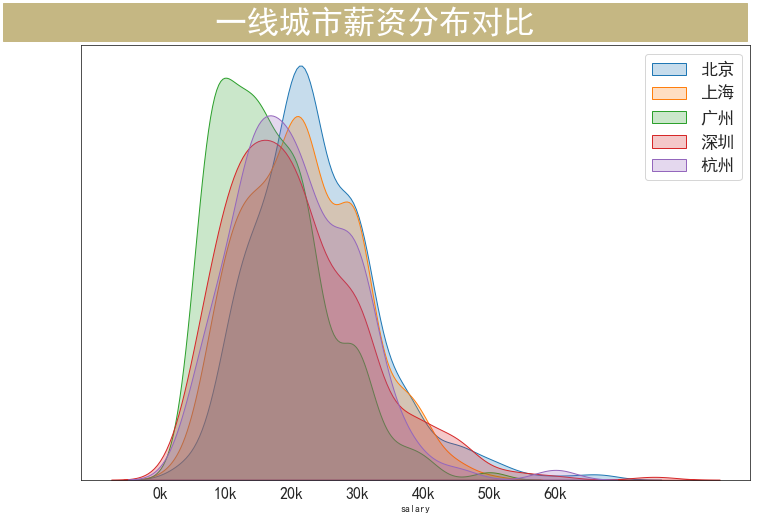

In [27]:
fig,ax = plt.subplots(figsize =(12,8))
fig.text(x = 0.04 , y = 0.90, s = '             一线城市薪资分布对比             ',fontsize = 32,weight = 'bold',color = 'white',backgroundcolor = '#c5b783')
sns.kdeplot(df1[df1['city']=='北京']['salary'],shade=True,label = '北京')
sns.kdeplot(df1[df1['city']=='上海']['salary'],shade=True,label = '上海')
sns.kdeplot(df1[df1['city']=='广州']['salary'],shade=True,label = '广州')
sns.kdeplot(df1[df1['city']=='深圳']['salary'],shade=True,label = '深圳')
sns.kdeplot(df1[df1['city']=='杭州']['salary'],shade=True,label = '杭州')
plt.tick_params(axis='both',which= 'major',labelsize = 16)
plt.xticks(np.arange(0,61,10),[str(i)+'k' for i in range(0,61,10)])
plt.yticks([])
plt.ylabel("")
plt.legend(fontsize = 'xx-large',fancybox = None)

###  工作经验与薪水的关系

In [28]:
corr = df1.pivot_table(index='city',columns='workYear',values= 'salary')
corr = corr[['在校/应届','1-3年','3-5年','5-10年']]

In [29]:
corr.loc[city_order]

workYear,在校/应届,1-3年,3-5年,5-10年
city,,,,
成都,10.750000,9.102564,13.281250,24.000000
长沙,9.500000,10.583333,13.944444,15.000000
广州,11.100000,11.862245,19.078571,27.633333
厦门,18.000000,12.250000,18.400000,28.166667
杭州,13.026316,14.887500,21.984536,29.843750
深圳,10.238095,15.454545,22.829710,32.990000
上海,11.065217,15.909524,23.686335,30.366667
北京,9.970588,18.452941,24.594444,31.315789


Text(87.078125, 0.5, '')

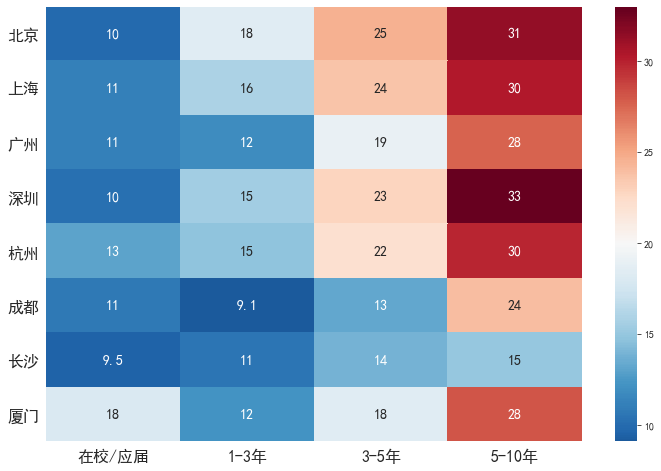

In [30]:
fig,ax = plt.subplots(figsize = (12,8))
sns.heatmap(corr.loc[df1['city'].value_counts().index],cmap = 'RdBu_r',center=20,annot=True,annot_kws={"fontsize":14})
plt.tick_params(axis='x',which = 'major',labelsize = 16)
plt.tick_params(axis = 'y',which = 'major',labelsize=16,labelrotation = 0)
plt.xlabel("")
plt.ylabel("")

 ### 

### 不同公司规模的用人需求

In [31]:
companysize_map = dict(zip(df1.companySize.value_counts().index,range(len(df1.companySize.value_counts().index),0,-1)))
workYear_map = {
    '5-10年':5,
    '3-5年':4,
    '1-3年':3,
    '1年以下':2,
    '在校/应届':1
}

In [32]:
#  对公司规模和工作年限进行数据映射
df1['company_size'] = df1.companySize.map(companysize_map)
df1['work_year'] = df1.workYear.map(workYear_map)

In [33]:
#  按公司规模的大小升序排列
df1 = df1.sort_values(by='company_size',ascending=True)

In [41]:
#  提取工作年限不为null 的数据
df_plot = df1.loc[~df1.work_year.isna()]
color_map = {
    5:"#ff0000",
    4:"#ffa500",
    3:"#c5b783",
    2:"#3c7f99",
    1:"#0000cd"
}
df_plot['color'] = df_plot.work_year.map(color_map)
df_plot.reset_index(drop = True,inplace = True)

g:\program files (x86)\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [42]:
df_plot.head()

,positionName,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,skillLables,company_size,work_year,color
0,数据分析师,拓端数据,上海,少于15人,本科,未融资,"数据服务,电商",17.5,1-3年,None,[数据服务],"[商业, 可视化, 数据分析, BI]",1,3.0,#c5b783
1,高级数据分析师,北京欧麦高广告有限责任公司,广州,少于15人,本科,未融资,移动互联网,35.0,5-10年,None,[],[],1,5.0,#ff0000
2,技能要求： 机器学习，Python，数据分析，算法,电芸智,深圳,少于15人,本科,不需要融资,"人工智能,软件开发",22.5,1-3年,None,[],"[计算机视觉, 图像处理, 模式识别, 算法]",1,3.0,#c5b783
3,高级数据分析师,纳彦管理咨询,深圳,少于15人,本科,不需要融资,企业服务,20.0,3-5年,None,[],[],1,4.0,#ffa500
4,数据分析师,志伏贸易,深圳,少于15人,本科,天使轮,"电商,移动互联网",17.5,3-5年,None,[],"[SPSS, 数据运营, 数据分析, 商业]",1,4.0,#ffa500


In [35]:
df1.financeStage.unique()

array(['未融资', 'A轮', '不需要融资', '天使轮', 'B轮', 'C轮', 'D轮及以上', '上市公司'],
      dtype=object)

In [43]:
def seed_scale_plot():
    seeds = np.arange(5) + 1
    y = np.zeros(len(seeds),dtype = int)
    s = seeds*100
    # 逆序
    colors = ["#ff0000","#ffa500","#c5b783","#3c7f99","#0000cd"][::-1]
    fig,ax = plt.subplots(figsize = (13.6,1))
    plt.scatter(seeds,y,s = s , c= colors,alpha=0.3)
    plt.scatter(seeds,y,c= colors)
    plt.box(False)
    plt.grid(False)
    plt.xticks(ticks=seeds,labels=list(workYear_map.keys())[::-1],fontsize = 14)
    plt.yticks(np.arange(1),labels=[' 经验:'],fontsize = 16)

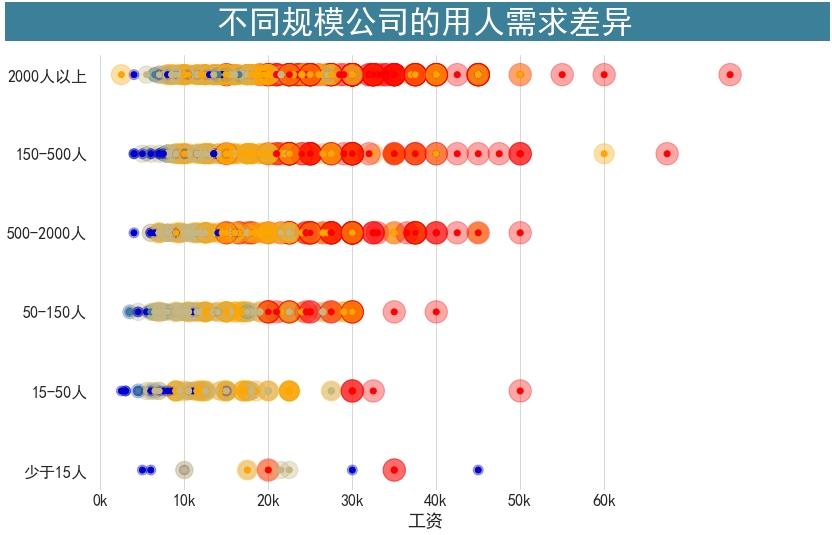

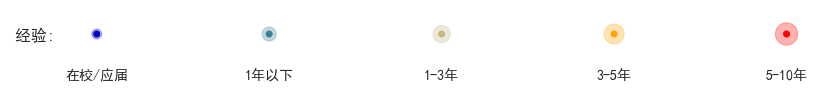

In [44]:
fig,ax =plt.subplots(figsize = (12,8))
fig.text(x = 0.03,y = 0.92,s = '             不同规模公司的用人需求差异            ',fontsize = 32,weight = 'bold',color = 'white',backgroundcolor = '#3c7f99')
plt.scatter(df_plot.salary,df_plot.companySize,s = df_plot.work_year*100,alpha=0.35,c =df_plot.color)
plt.scatter(df_plot.salary,df_plot.companySize,c = df_plot.color.values.tolist())
plt.tick_params(axis = 'both',which = 'both',length = 0)
plt.tick_params(axis = 'both',which = 'major',labelsize=16)
ax.xaxis.grid(which='both',linewidth = 0.75)
plt.xticks(np.arange(0,61,10),[str(i)+'k' for i in range(0,61,10)])
plt.xlabel('工资',fontsize = 18)
plt.box(False)
seed_scale_plot()


### 学历要求

<Figure size 864x576 with 0 Axes>

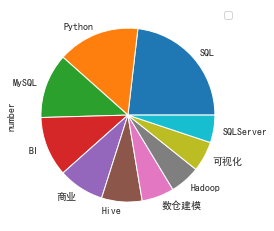

In [38]:
plt.figure(figsize=(12,8))
skill_df.set_index('skill').plot(kind = 'pie',subplots=True)
plt.legend("")

In [39]:
# 
education = df1.education.value_counts(normalize=True)

In [40]:
from pyecharts.commons.utils import JsCode
def new_label_opts():
    return opts.LabelOpts(formatter=JsCode('学历要求'))
pie = (
    Pie()
    .add(
        "",
        [list(z) for z in zip(education.index , np.round(education.values,4))],
        center= ["50%","50%"],
        radius=["50%","75%"],
        label_opts = new_label_opts()
        )
    .set_global_opts(
        title_opts = opts.TitleOpts(title=""),
        legend_opts = opts.LegendOpts(
            is_show=False
        )
    )
    .set_series_opts(label_opts = opts.LabelOpts(formatter="{b}:{d}%"))
)
pie.render_notebook()